In [2]:
import cv2
import numpy as np

def sketch_to_filled_mask(
    sketch_path: str,
    mask_path: str,
    thresh_value: int = 200,
    closing_kernel_size: int = 15
) -> None:

    # Load and grayscale
    img = cv2.imread(sketch_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not load image at {sketch_path}")

    # Invert + threshold: lines become white on black
    _, th = cv2.threshold(img, thresh_value, 255, cv2.THRESH_BINARY_INV)

    # Morphological closing to bridge gaps
    kernel = np.ones((closing_kernel_size, closing_kernel_size), np.uint8)
    closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)

    # Find external contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw filled contours into mask
    mask = np.zeros_like(closed)
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

    # Save result
    cv2.imwrite(mask_path, mask)

if __name__ == "__main__":
    sketch_to_filled_mask(
        sketch_path="dataset/images/0/apple_n07739125_4340-1_sketch.png",
        mask_path="filled_mask.png",
        thresh_value=200,
        closing_kernel_size=15
    )
    print("Mask saved to filled_mask.png")


Mask saved to filled_mask.png


In [8]:
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, AutoencoderKL
from PIL import Image
import torch

scribble_controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-scribble", torch_dtype=torch.float32
)

pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=scribble_controlnet,
    torch_dtype=torch.float32
).to("cpu")

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float32)
pipe.vae = vae
target_size = (256, 256)
image = Image.open("table.jpg").convert("RGB").resize(target_size, resample=Image.BILINEAR)
mask = Image.open("filled_mask.png").convert("L")  # white=editable
scribble = Image.open("dataset/images/0/apple_n07739125_4340-1_sketch.png").convert("RGB")

prompt = "red apple"

result = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask,
    control_image=scribble,
    num_inference_steps=30,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
)

# Save result
result.images[0].save("edited_result.png")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

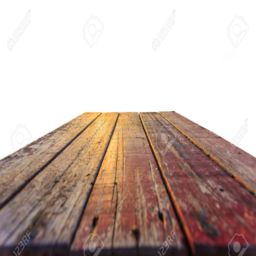

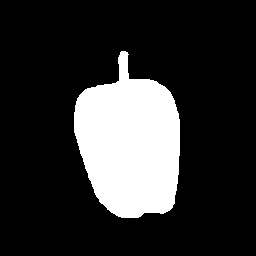

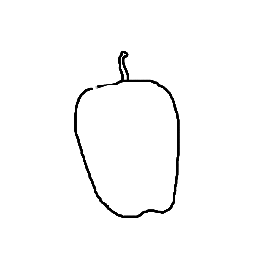

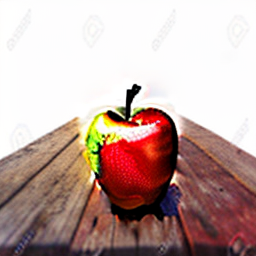

In [9]:
from IPython.display import display

# assuming you’ve already loaded:
# image, mask, scribble, result

display(image)             # original
display(mask)              # inpaint mask (L mode)
display(scribble)          # your sketch
display(result.images[0])  # the edited output
